# Numerische Methoden für Differentialgleichungen
## Aufgabenblatt 7
*gelöst von Stollmayer Max*

_Für die Konvektionsgleichung (hyperbolische PDE) mit periodischen Randbedingungen und konstantem Koeffizienten_

\begin{cases}
\partial_t u(x,t) + a\cdot\partial_x u(x,t) = 0, \quad x\in D,\ t\ge 0 \\
u(x,0)=u_0(x), \quad x\in D \\
u(0,t)=u(1,t), \quad t\ge 0
\end{cases}

_ist das Upwind- und das Lax-Friedrichs-Verfahren zu implementieren._

#### Konstruktion

Man lege für $x$ und $t$ ein Gitter fest mit Schrittweiten $h$ in $x$-Richtung und $k$ und $t$-Richtung, so dass $u_{m,n} \approx u(x_m,t_n)$ mit $x_m = x_0 + m h$ und $t_n = t_0 + n h.$ Verschiedene Verfahren ergeben sich aus der Anordnung der finiten Differenzen in die Koordinatenrichtungen:

$(1) \quad$ Zeit-Vorwärts & Ort-Vorwärts: $\dfrac{u_{m,n+1}-u_{m,n}}{k} + a \dfrac{u_{m+1,n}-u_{m,n}}{h} = 0$

$(2) \quad$ Zeit-Vorwärts & Ort-Rückwärts: $\dfrac{u_{m,n+1}-u_{m,n}}{k} + a \dfrac{u_{m,n}-u_{m-1,n}}{h} = 0$

Die Upwind-Methode benutzt aus Konvergenzgründen nun $(1)$ für $a<0$ und $(2)$ für $a>0.$

Das Lax-Friedrichs-Verfahrens lautet $\dfrac{u_{m,n+1}- \frac{1}{2} (u_{m+1,n} + u_{m-1,n})}{k} + a \dfrac{u_{m+1,n}-u_{m-1,n}}{2h} = 0.$

#### Konvergenz

Die Konsistenzordnung lässt sich analog zu den vorherigen Aufgaben mit einer Taylorentwicklung ermitteln und ist für beide Verfahren 1.

Wir nennen eine Methode stabil, falls $\forall T > 0 \ \exists C_T > 0,$ so dass das Ergebnis der Methode $\|U_n\|_1 \le C_T \|U_0\|_1 \ \forall n < \frac{T}{k}$ erfüllt, wobei $U_n$ die Folge der Werte in $x$-Richtung zur Zeit $t_n$ bezeichnet. Nach einer kurzen Rechnung sieht man, dass beide Verfahren stabil sind, falls $\big|\dfrac{a k}{h}\big| \le 1$ gilt.

Also sind sie nach dem Äquivalenzsatz von Lax konvergent mit Ordnung 1, falls sie diese [Courant-Friedrichs-Lewy-Bedingung](https://de.wikipedia.org/wiki/CFL-Zahl) erfüllen.

#### Implementierung

In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11.2, 6.3))
plt.rc("font", size=12)
plt.rc("axes", edgecolor="white")
plt.rc("legend", frameon=True, framealpha=0.8, facecolor="white", edgecolor="white")

In [2]:
def Upwind(a, u0, grid):
    '''
    Solves the one-dimensional, linear, hyperbolic PDE u_t + a * u_x = 0 with initial value function u0
    and periodic boundary values on the griven grid using the Upwind scheme.
    
    returns 2D-array of function values
    
    a ...... constant
    u0 ..... intial value function in the x variable
    grid ... tuple (x, t) where x and t are N-by-M-arrays
    '''
    
    
    x, t = grid
    N, M = x.shape
    
    u = np.zeros((N, M))
    u[0] = u0(x[0])
    
    if a >= 0:
        for n in range(N-1):
            
            # values on inner grid
            for m in range(1, M):
                dx = x[n, m] - x[n, m-1]
                dt = t[n+1, m] - t[n, m]
                u[n+1, m] = u[n, m] - a * dt / dx * (u[n, m] - u[n, m-1])
            
            # periodic boundary values
            u[n+1, 0] = u[n+1, -1]
    else:
        for n in range(N-1):
            
            # values on inner grid
            for m in range(M-1):
                dx = x[n, m+1] - x[n, m]
                dt = t[n+1, m] - t[n, m]
                u[n+1, m] = u[n, m] - a * dt / dx * (u[n, m+1] - u[n, m])
                
            # periodic boundary values
            u[n+1, -1] = u[n+1, 0]
    
    return u

In [3]:
def LaxFriedrichs(a, u0, grid):
    '''
    Solves the one-dimensional, linear, hyperbolic PDE u_t + a * u_x = 0 with initial value function u0
    and periodic boundary values on the griven grid using the Lax-Friedrichs method.
    
    returns 2D-array of function values
    
    a ...... constant
    u0 ..... intial value function in the x variable
    grid ... tuple (x, t) where x and t are N-by-M-arrays
    '''
    
    
    x, t = grid
    N, M = x.shape
    
    u = np.zeros((N, M))
    u[0] = u0(x[0])
    
    for n in range(N-1):
        
        # values on inner grid
        for m in range(1, M-1):
            dx = x[n, m+1] - x[n, m-1]
            dt = t[n+1, m] - t[n, m]
            u[n+1, m] = (u[n, m+1] + u[n, m-1]) / 2 - a * dt / dx * (u[n, m+1] - u[n, m-1])
        
        # periodic boundary values
        dx = x[n, -1] - x[n, -2] + x[n, 1] - x[n, 0]
        dt = t[n+1, 0] - t[n, 0]
        u[n+1, 0] = u[n+1, -1] = (u[n, 1] + u[n, -2]) / 2 - a * dt / dx * (u[n, 1] - u[n, -2])
        
    return u

#### Test

Nun testen wir die Verfahren auf $D=[0,1]$ für $a=-1$ und $u_0(x) = \sin(2\pi x)$ und vergleichen die Resultate mit der exakten Lösung $u_0(x-a t).$ Um die CFL-Bedingung zu erfüllen, verwerden wir bei $N$ Ortsschritten $N+1$ Zeitschritte, damit erhalten wir in diesem Fall konvergente Verfahren.

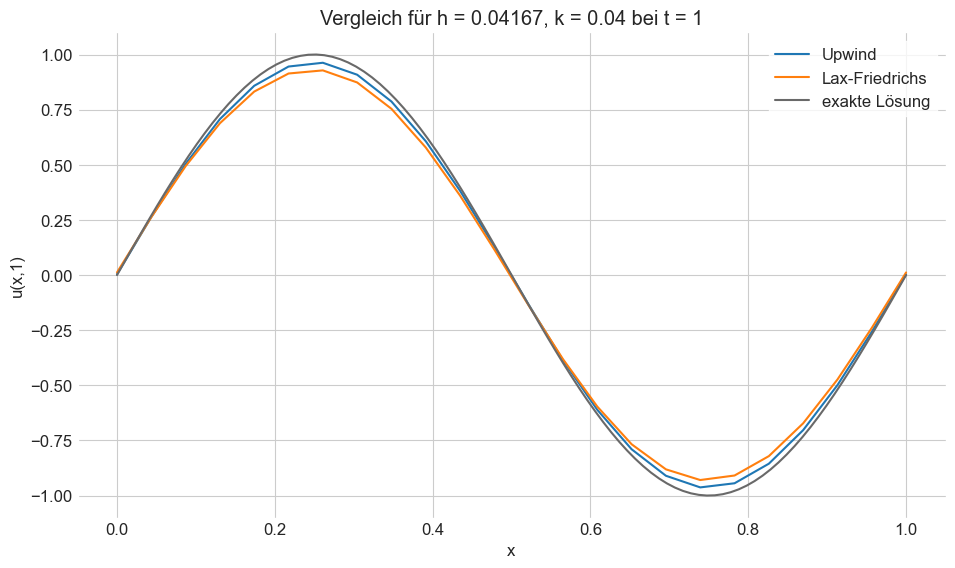

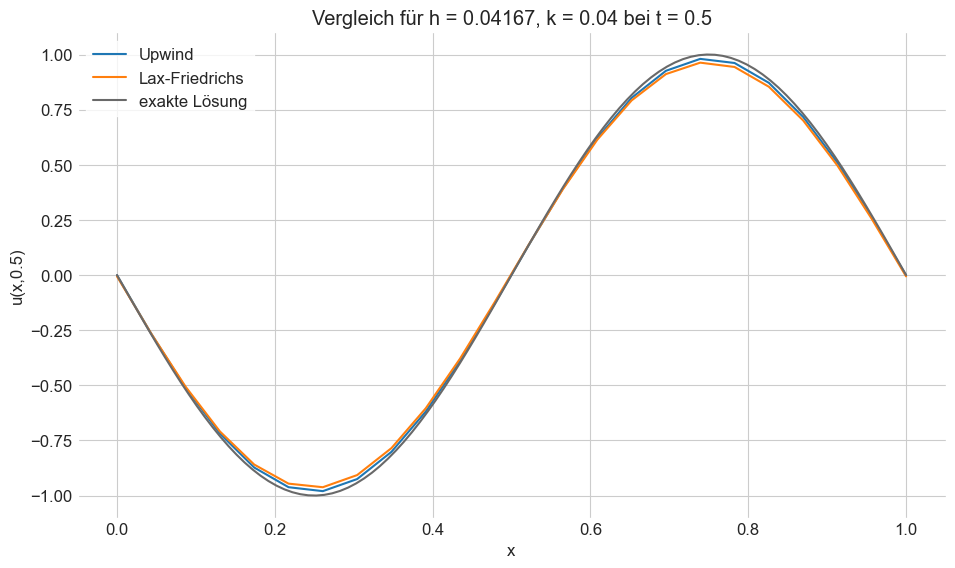

In [4]:
a = -1

def u0(x):
    return np.sin(2 * np.pi * x)

def exact(x, t):
    return u0(x - a * t)

N = 24
M = N+1
x = np.linspace(0, 1, N)
t = np.linspace(0, 1, M)
grid = np.meshgrid(x, t)
X = np.linspace(0, 1, 100)

u1 = Upwind(a, u0, grid)
u2 = LaxFriedrichs(a, u0, grid)

plt.plot(x, u1[-1], label="Upwind")
plt.plot(x, u2[-1], label="Lax-Friedrichs")
plt.plot(X, exact(X, 1), color="dimgray", label="exakte Lösung")
plt.title(f"Vergleich für h = {1/N:.5f}, k = {1/M:.2f} bei t = 1")
plt.xlabel("x")
plt.ylabel("u(x,1)")
plt.legend()
plt.show()

plt.plot(x, u1[len(u1)//2], label="Upwind")
plt.plot(x, u2[len(u2)//2], label="Lax-Friedrichs")
plt.plot(X, exact(X, 0.5), color="dimgray", label="exakte Lösung")
plt.title(f"Vergleich für h = {1/N:.5f}, k = {1/M:.2f} bei t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,0.5)")
plt.legend()
plt.show()

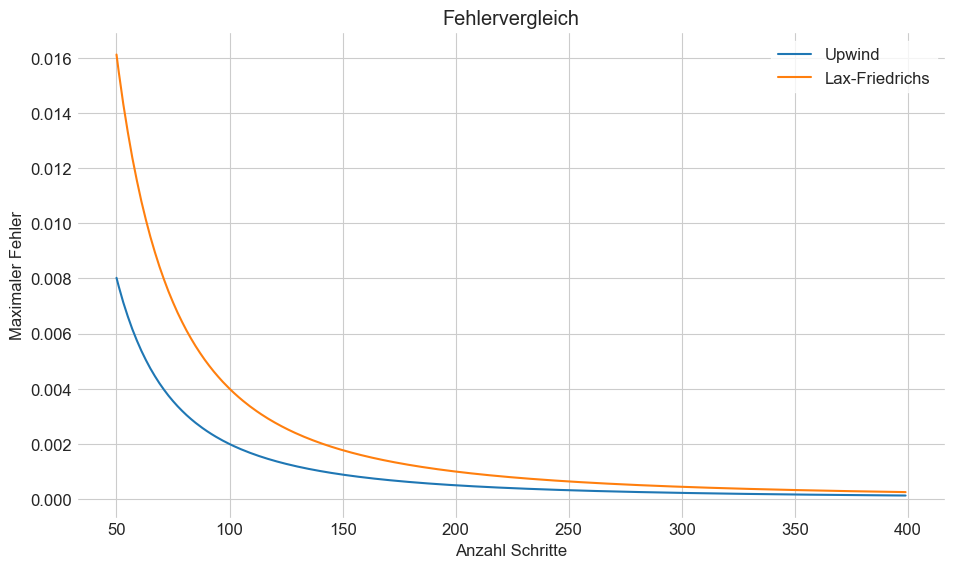

Approximierte Konvergenzordnung
Upwind:         2.01
Lax-Friedrichs: 2.01


In [5]:
def errorUW(N, c):
    M = int(N / c)
    X = np.linspace(0, 1, N)
    T = np.linspace(0, 1, M)
    grid = np.meshgrid(X, T)
    u = Upwind(a, u0, grid)
    return max(np.abs(exact(*grid) - u).flatten())

def errorLF(N, c):
    M = int(N / c)
    X = np.linspace(0, 1, N)
    T = np.linspace(0, 1, M)
    grid = np.meshgrid(X, T)
    u = LaxFriedrichs(a, u0, grid)
    return max(np.abs(exact(*grid) - u).flatten())

def order(errors):
    return (np.log(errors[-1]) - np.log(errors[0])) / (np.log(steps[0]) - np.log(steps[-1]))

steps = np.arange(50, 400)
errors1 = [errorUW(N, N/(N+1)) for N in steps]
errors2 = [errorLF(N, N/(N+1)) for N in steps]

plt.plot(steps, errors1, label="Upwind")
plt.plot(steps, errors2, label="Lax-Friedrichs")
#plt.yscale("log")
plt.xlabel("Anzahl Schritte")
plt.ylabel("Maximaler Fehler")
plt.title(f"Fehlervergleich")
plt.legend()
plt.show()

print(f"Approximierte Konvergenzordnung")
print(f"Upwind:         {order(errors1):.2f}")
print(f"Lax-Friedrichs: {order(errors2):.2f}")

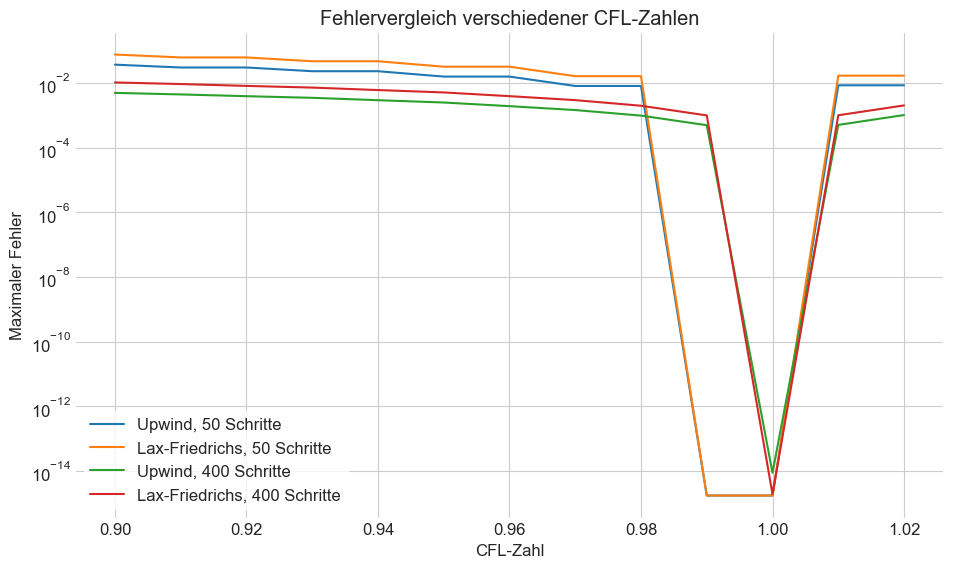

In [6]:
Cs = np.linspace(0.9, 1.02, 13)
errors1 = [errorUW(50, c) for c in Cs]
errors2 = [errorLF(50, c) for c in Cs]
errors3 = [errorUW(400, c) for c in Cs]
errors4 = [errorLF(400, c) for c in Cs]

plt.plot(Cs, errors1, label="Upwind, 50 Schritte")
plt.plot(Cs, errors2, label="Lax-Friedrichs, 50 Schritte")
plt.plot(Cs, errors3, label="Upwind, 400 Schritte")
plt.plot(Cs, errors4, label="Lax-Friedrichs, 400 Schritte")
plt.yscale("log")
plt.xlabel("CFL-Zahl")
plt.ylabel("Maximaler Fehler")
plt.title(f"Fehlervergleich verschiedener CFL-Zahlen")
plt.legend()
plt.show()

#### Beobachtungen



Das Upwind-Verfahren erzielt bessere Ergebnisse für eine CFL-Zahl echt kleiner 1. Die berechneten Konvergenzraten übertreffen sogar die analytisch hergeleiteten. 